In [1]:
##################################################
# Smoothing Methods (Holt-Winters)
##################################################

![alt metni](111.png)

## Kütüphanelerlin Yüklenmesi

In [4]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
import seaborn as sns
sns.set_style("darkgrid") 

warnings.filterwarnings('ignore')

############################
## Veri Seti
############################

### Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
### Period of Record: March 1958 - December 2001

In [6]:
data = sm.datasets.co2.load_pandas()

In [7]:
y = data.data

## EDA

In [9]:
y.head(20)

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
1958-05-03,316.9
1958-05-10,NaN
1958-05-17,317.5
1958-05-24,317.9
1958-05-31,NaN


In [10]:
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB


In [11]:
y_mn = y['co2'].resample('MS').mean()

In [12]:
y_mn.head(20)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
1958-08-01    314.950000
1958-09-01    313.500000
1958-10-01           NaN
1958-11-01    313.425000
1958-12-01    314.700000
1959-01-01    315.500000
1959-02-01    316.700000
1959-03-01    316.733333
1959-04-01    317.675000
1959-05-01    318.325000
1959-06-01    318.025000
1959-07-01    316.525000
1959-08-01    314.900000
1959-09-01    313.825000
1959-10-01    313.400000
Freq: MS, Name: co2, dtype: float64

In [13]:
y.isnull().sum()

co2    59
dtype: int64

In [14]:
y_mn.isnull().sum()

5

### Nan değerden önce ve sonra gelen iki değerin orta noktasını kullanarak Nan değeri doldurduk.

In [16]:
y_mn.interpolate(method='linear', inplace=True)

In [17]:
y_mn.head(20)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    316.529167
1958-07-01    315.625000
1958-08-01    314.950000
1958-09-01    313.500000
1958-10-01    313.462500
1958-11-01    313.425000
1958-12-01    314.700000
1959-01-01    315.500000
1959-02-01    316.700000
1959-03-01    316.733333
1959-04-01    317.675000
1959-05-01    318.325000
1959-06-01    318.025000
1959-07-01    316.525000
1959-08-01    314.900000
1959-09-01    313.825000
1959-10-01    313.400000
Freq: MS, Name: co2, dtype: float64

In [18]:
len(y_mn)

526

<Axes: >

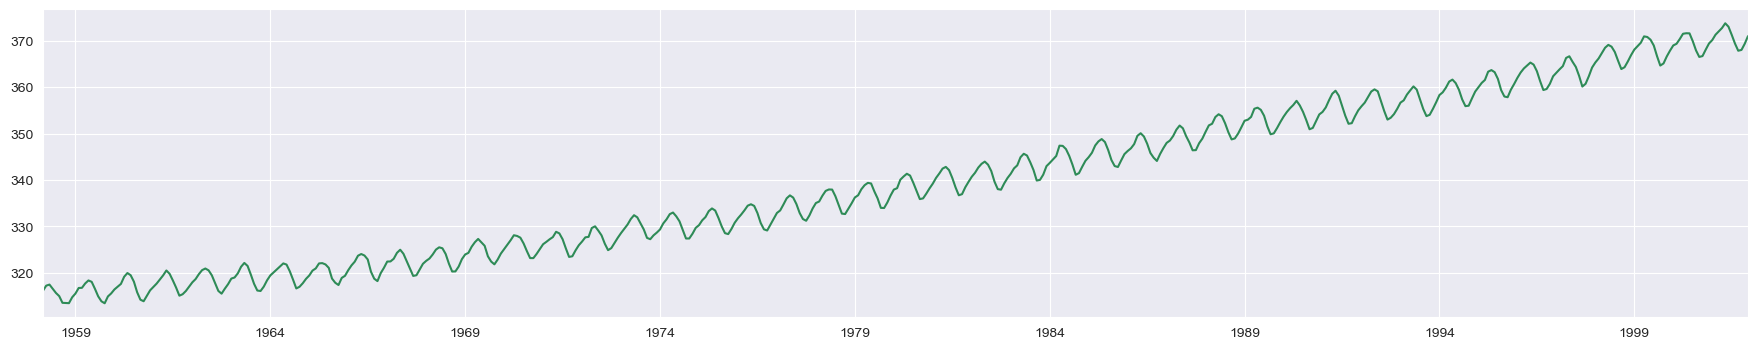

In [19]:
y_mn.plot(figsize=(22, 4), color='seagreen')

## Test ve Train set oluşturma 

In [21]:
############################
# Holdout
############################

train = y_mn[:'1997-12-01']
len(train)  # 478 ay

478

In [22]:
# 1998'ilk ayından 2001'in sonuna kadar test set.
test = y_mn['1998-01-01':]
len(test)  # 48 ay

48

## Durağanlık Testi (Dickey-Fuller Testi)

In [24]:
def is_stationary(y_mn):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y_mn)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

In [25]:
is_stationary(y_mn)

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


In [26]:
# Zaman Serisi Bileşenleri ve Durağanlık Testi

def ts_decompose(y_mn, model="additive", stationary=False):
    result = seasonal_decompose(y_mn, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(22)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y_mn, 'k', label='Original ' + model,color='seagreen')
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend',color='seagreen')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)),color='seagreen')
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)),color='seagreen')
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y_mn)

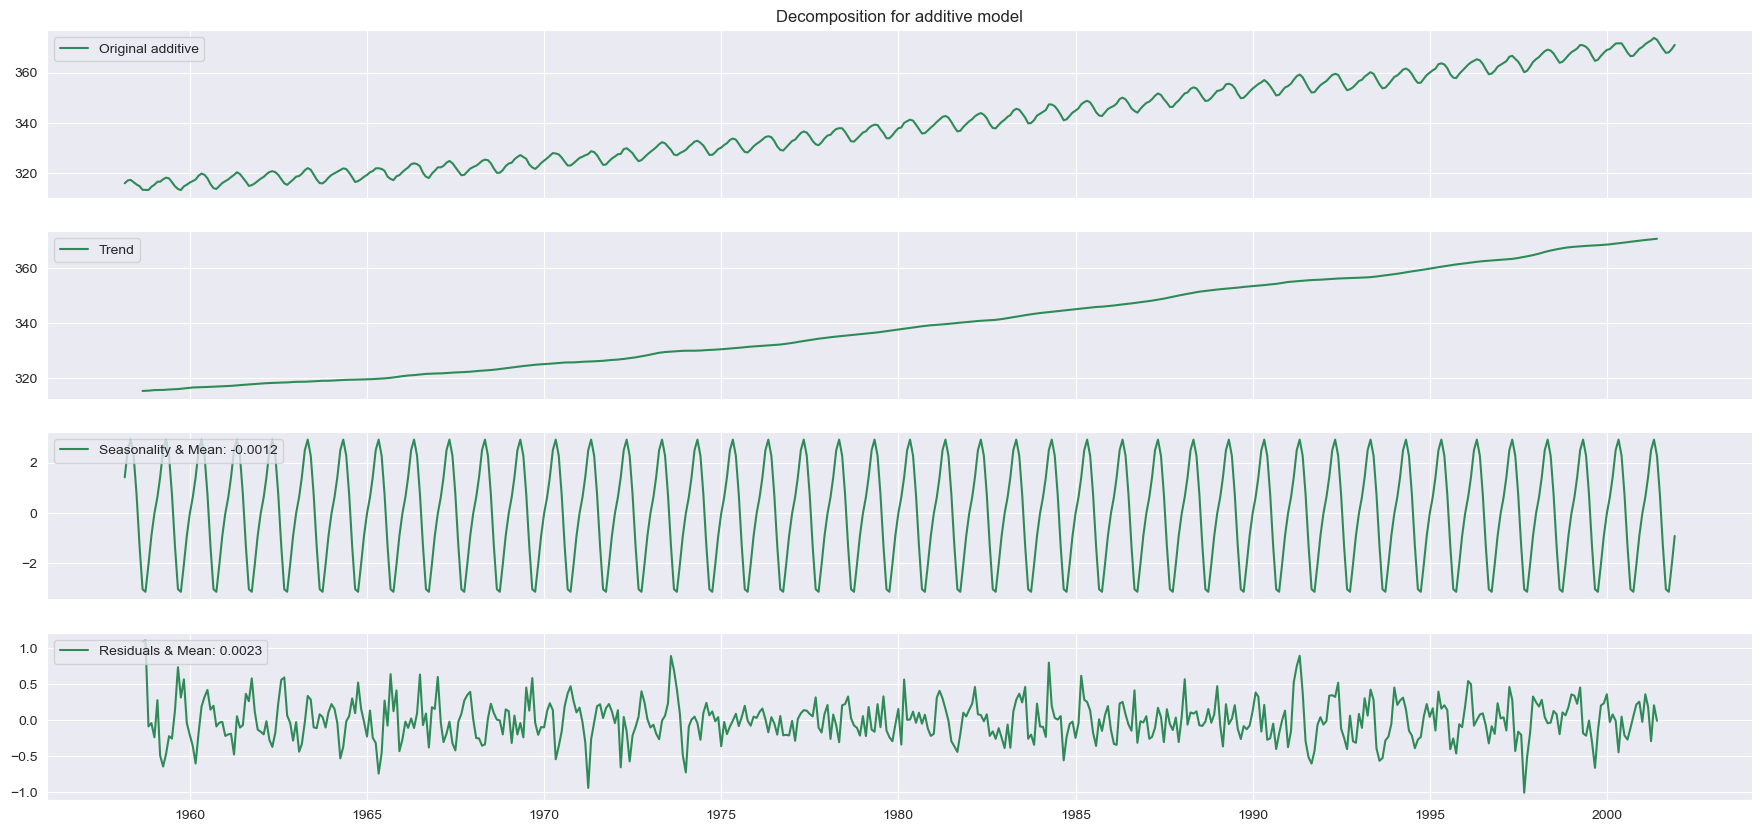

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


In [27]:
ts_decompose(y_mn, stationary=True)

## Model Kurulumu

In [29]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.5)

In [30]:
y_pred = ses_model.forecast(48)

In [31]:
y_pred.head(20)

1998-01-01    363.057044
1998-02-01    363.057044
1998-03-01    363.057044
1998-04-01    363.057044
1998-05-01    363.057044
1998-06-01    363.057044
1998-07-01    363.057044
1998-08-01    363.057044
1998-09-01    363.057044
1998-10-01    363.057044
1998-11-01    363.057044
1998-12-01    363.057044
1999-01-01    363.057044
1999-02-01    363.057044
1999-03-01    363.057044
1999-04-01    363.057044
1999-05-01    363.057044
1999-06-01    363.057044
1999-07-01    363.057044
1999-08-01    363.057044
Freq: MS, dtype: float64

## Sonuçların İncelenmesi

In [33]:
mean_absolute_error(test, y_pred)

5.706393369643809

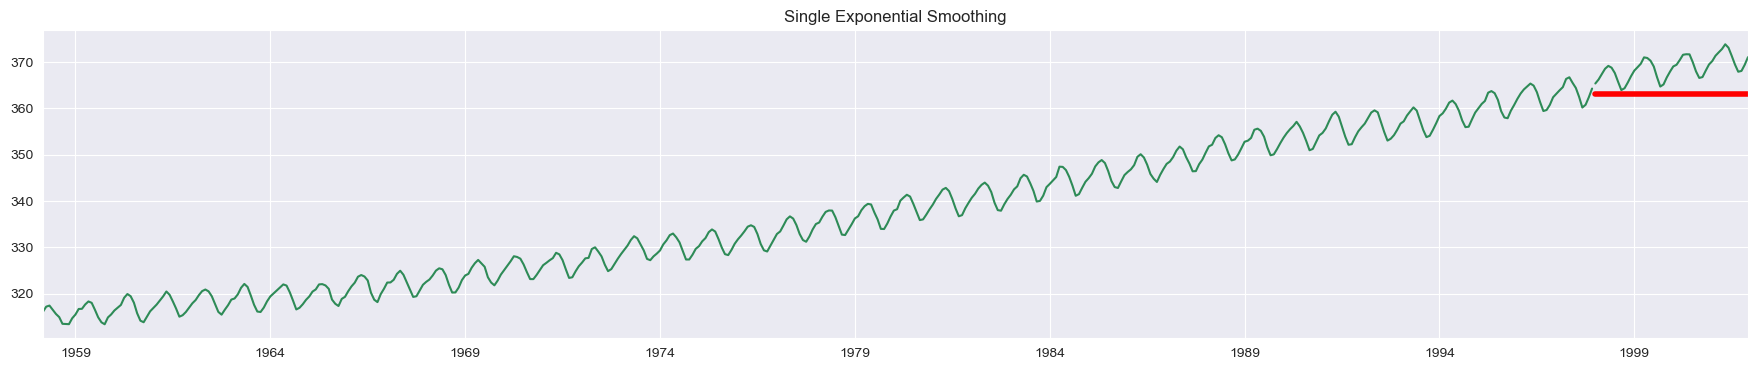

In [34]:
train.plot(title="Single Exponential Smoothing", color='seagreen',figsize=(22, 4))
test.plot(color='seagreen')
y_pred.plot(color='red', linewidth=4)
plt.show()


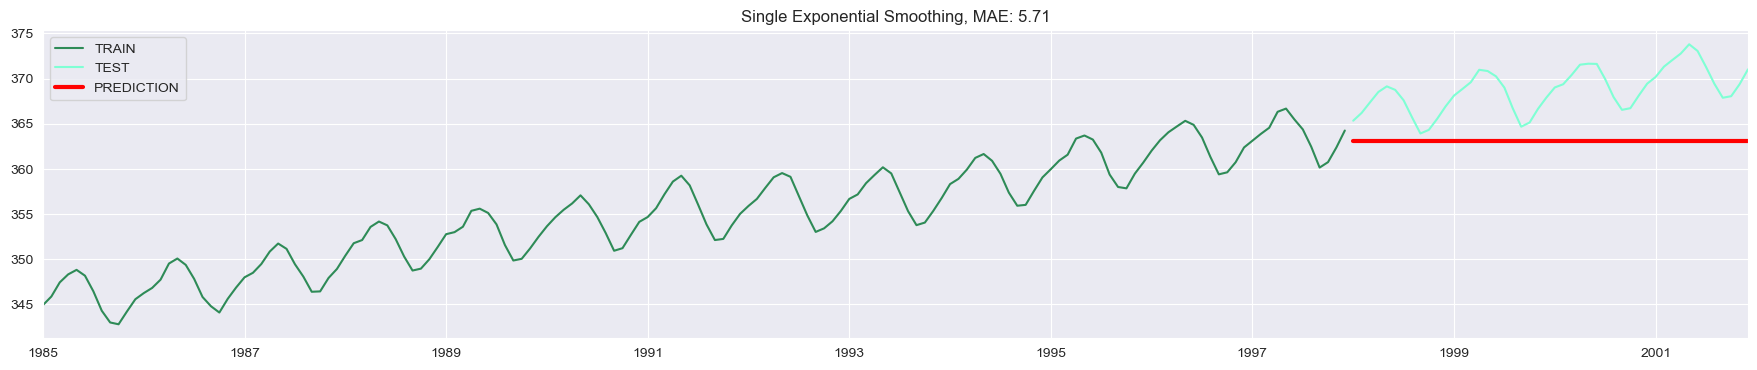

In [35]:
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    
    plt.figure(figsize=(22, 4))
    
    train["1985":].plot(legend=True, label="TRAIN", color='seagreen', title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", color='aquamarine')
    y_pred.plot(legend=True, label="PREDICTION", color='red', linewidth=3)
    
    plt.show()
plot_co2(train, test, y_pred, "Single Exponential Smoothing")

In [36]:
ses_model.params

{'smoothing_level': 0.5,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 316.1,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

## Hyperparameter Optimization

In [38]:
def ses_optimizer(train, alphas, step=48):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

alphas = np.arange(0.8, 1, 0.01)

In [39]:
ses_optimizer(train, alphas)

alpha: 0.8 mae: 4.953
alpha: 0.81 mae: 4.9282
alpha: 0.82 mae: 4.9035
alpha: 0.83 mae: 4.8792
alpha: 0.84 mae: 4.8551
alpha: 0.85 mae: 4.8316
alpha: 0.86 mae: 4.8091
alpha: 0.87 mae: 4.7869
alpha: 0.88 mae: 4.765
alpha: 0.89 mae: 4.7434
alpha: 0.9 mae: 4.7221
alpha: 0.91 mae: 4.7012
alpha: 0.92 mae: 4.6805
alpha: 0.93 mae: 4.6602
alpha: 0.94 mae: 4.6402
alpha: 0.95 mae: 4.6205
alpha: 0.96 mae: 4.6012
alpha: 0.97 mae: 4.5822
alpha: 0.98 mae: 4.5634
alpha: 0.99 mae: 4.5451
best_alpha: 0.99 best_mae: 4.5451


(0.9900000000000002, 4.545056761011273)

In [40]:
best_alpha, best_mae = ses_optimizer(train, alphas)

alpha: 0.8 mae: 4.953
alpha: 0.81 mae: 4.9282
alpha: 0.82 mae: 4.9035
alpha: 0.83 mae: 4.8792
alpha: 0.84 mae: 4.8551
alpha: 0.85 mae: 4.8316
alpha: 0.86 mae: 4.8091
alpha: 0.87 mae: 4.7869
alpha: 0.88 mae: 4.765
alpha: 0.89 mae: 4.7434
alpha: 0.9 mae: 4.7221
alpha: 0.91 mae: 4.7012
alpha: 0.92 mae: 4.6805
alpha: 0.93 mae: 4.6602
alpha: 0.94 mae: 4.6402
alpha: 0.95 mae: 4.6205
alpha: 0.96 mae: 4.6012
alpha: 0.97 mae: 4.5822
alpha: 0.98 mae: 4.5634
alpha: 0.99 mae: 4.5451
best_alpha: 0.99 best_mae: 4.5451


## Final Model

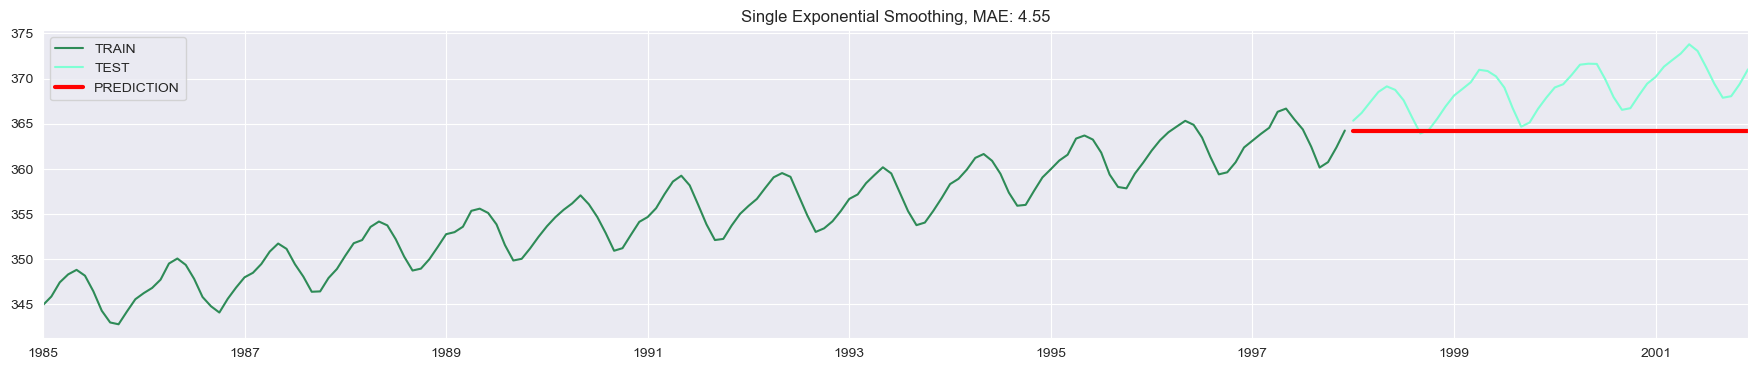

In [42]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(48)

plot_co2(train, test, y_pred, "Single Exponential Smoothing")